# Sounds of the Street: A Convolutional Neural Network Implementation in PyTorch 

_"Small-data" project on audio classification by Ben Kim_

***Notice:***
_To run the dataloader, and by proxy this notebook, the UrbanSound8K dataset must be locally downloaded in the current working directory ({cwd}/UrbanSound8K/). It is cited in the README of this repo, but not included. The full dataset is around 8 GB._

## Introduction

In this project I will be implementing a Convolutional Neural Network to identify the origin of various audio samples. The dataset I am working with is the UrbanSound8K Dataset, which contains 8,732 labeled sound excerpts of urban sounds. They are labeled under 10 different urban sound classes, which include sounds like air conditioners, car horns, children playing, and more. It is a well-balanced dataset for sound classification.

Each sound file is sampled at 44.1 kHz and thee dataset is divided into 10 folds for cross-validation purposes, making it easier to implement a k-fold validation strategy.

#### The value of an algorithm

A typical benchmark for this classification model would be around **70-80% accuracy** depending on the complexity of the model and the training strategy. If this classifier is used in real-time applications, the model should have minimal latency and high enough accuracy to reliably distinguish between sounds. If deployed in a system that affects human decisions or safety (e.g., traffic monitoring, emergency detection), the algorithms's false positive and false negative rates would need to be examined with care. 

Sound classification can provide valuable insights for many stakeholders as it can aid in the identification and mapping of noise pollution patterns, which can be associated with health risks. Law enforcement might use sound classifiers to automatically detect events such as gunshots, sirens, or other emergency signals. 

Of course, value is not without risk. Sound classification systems in public places can lead to privacy concerns, especially if data associated with personal behavior is collected. Misclassifying sounds with false positives could result in societal or operational disruptions (e.g., a car horn mistaken for a gunshot). Conversely, false positives could result in neglected emergencies (e.g., a gunshot mistaken for a car horn). Additionally, if the data does not reflect diverse environments, the model may perform poorly in underrepresented areas due to biasing. These risks may be mitigated with data transparency, model explainability, continuous learning, and bias consciousness.

## Initializing the Dataset

In [1]:
# Import requirements for this notebook:

import os
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import json

from urbansounds import UrbanSoundDataset # A data preprocessor I made to uniformly alter the dataset for the CNN to use
from classify_audio import * # A bunch of helper functions I wrthatote to model, train, and visualize the CNN's behavior

# Initialize device
cwd = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


#### Audio preprocessing

I've preprocessed the UrbanSound8K dataset for the needs of this project in `urbansounds.py`. `UrbanSoundDataset` will alter the audio files (by default, WAV files) as needed as follows:
* **Resampling**: If needed, audio snippet will be resampled to a designated sample rate
* **Cutting**: If longer than the designated number of samples, the snippet is shortened.
* **Padding**: If shorter than the designated number of samples, the snippet is right-padded with zeros (silence)
* **Mixdown**: If the audio snippet has two channels for stereo, the channels will be averaged into one channel for mono processing.

Now each audio snippet has exactly the same length, sample rate, and dimension (should now be a one-dimensional vector).

As it stands, these processed WAV files are not very useful to us. They are strictly raw waveforms in the time domain, and there is no apparent way to extract feature patterns from them in this one-dimensional form. To allow a convolutional network to interpret audio, we can represent each signal in both the time and frequency domain using a the **mel spectrogram** transform in the `TorchAudio` library. 

A mel spectrogram takes the short-time Fourier transform of a sound signal and maps it to a mel scale (a perceptual scale of pitch emulating the human ear). It is commonly used in audio processing and speech recognition tasks, especially for analyzing and classifying music and environmental noises. **Essentially, this will represent our sound in two-dimensional space: one representing time and the other representing frequency.** Scalar datapoints within these spectrograms represent the amplitude of each frequency component at each moment in time. 

I have slightly modified the `TorchAudio` Mel Spectrogram transform by scaling the amplitude values logarithmically, as loudness is percieved on a log scale. This will hopefully allow our CNN to extract features that would otherwise be too subtle to matter.

In [2]:
SAMPLE_RATE = 22050 # Hz
NUM_SAMPLES = SAMPLE_RATE * 4 # Four seconds of audio sampled at 22.05 kHz

mel_spectrogram = LogMelSpectrogram(
    sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64
)

usd = UrbanSoundDataset(
    annotations_file=f"{cwd}/UrbanSound8K/metadata/UrbanSound8K.csv", 
    audio_dir=f"{cwd}/UrbanSound8K/audio", 
    transformation=mel_spectrogram, 
    target_sample_rate=SAMPLE_RATE, 
    num_samples=NUM_SAMPLES, 
    device=device
)

print(f"There are {len(usd)} samples in this dataset.")

There are 8732 samples in this dataset.


#### Visualizing mel spectrograms

When sampled at 22,050 Hz, a snippet of exactly 4 seconds (with the transform parameters decided above) will have the mel spectrogram size (1, 64, 173). This is for:
* 1 mono channel
* 64 mel bins (percieved pitch designations for frequency)
* 173 time frames (time units; the summation of which represents 4 seconds of sound sampled at 22.05 kHz)

If we simply plot these spectrograms, we can already identify some patterns between the different sorts of sounds. Robust edges in our graphs represent powerful impulses at different intervals of time that could reasonably be explained by gunshots, or perhaps a barking dog. If these impulses are very rapid, we may guess that it could be the sound of a jackhammer. A particularly interesting feature is the shared, gradually oscillating frequency seen in the siren graphs, similar to how the Doppler effect makes a passing ambulance siren modulate. It is these and hopefully much more complex features that our convolutional network will extract from this transformed data. 

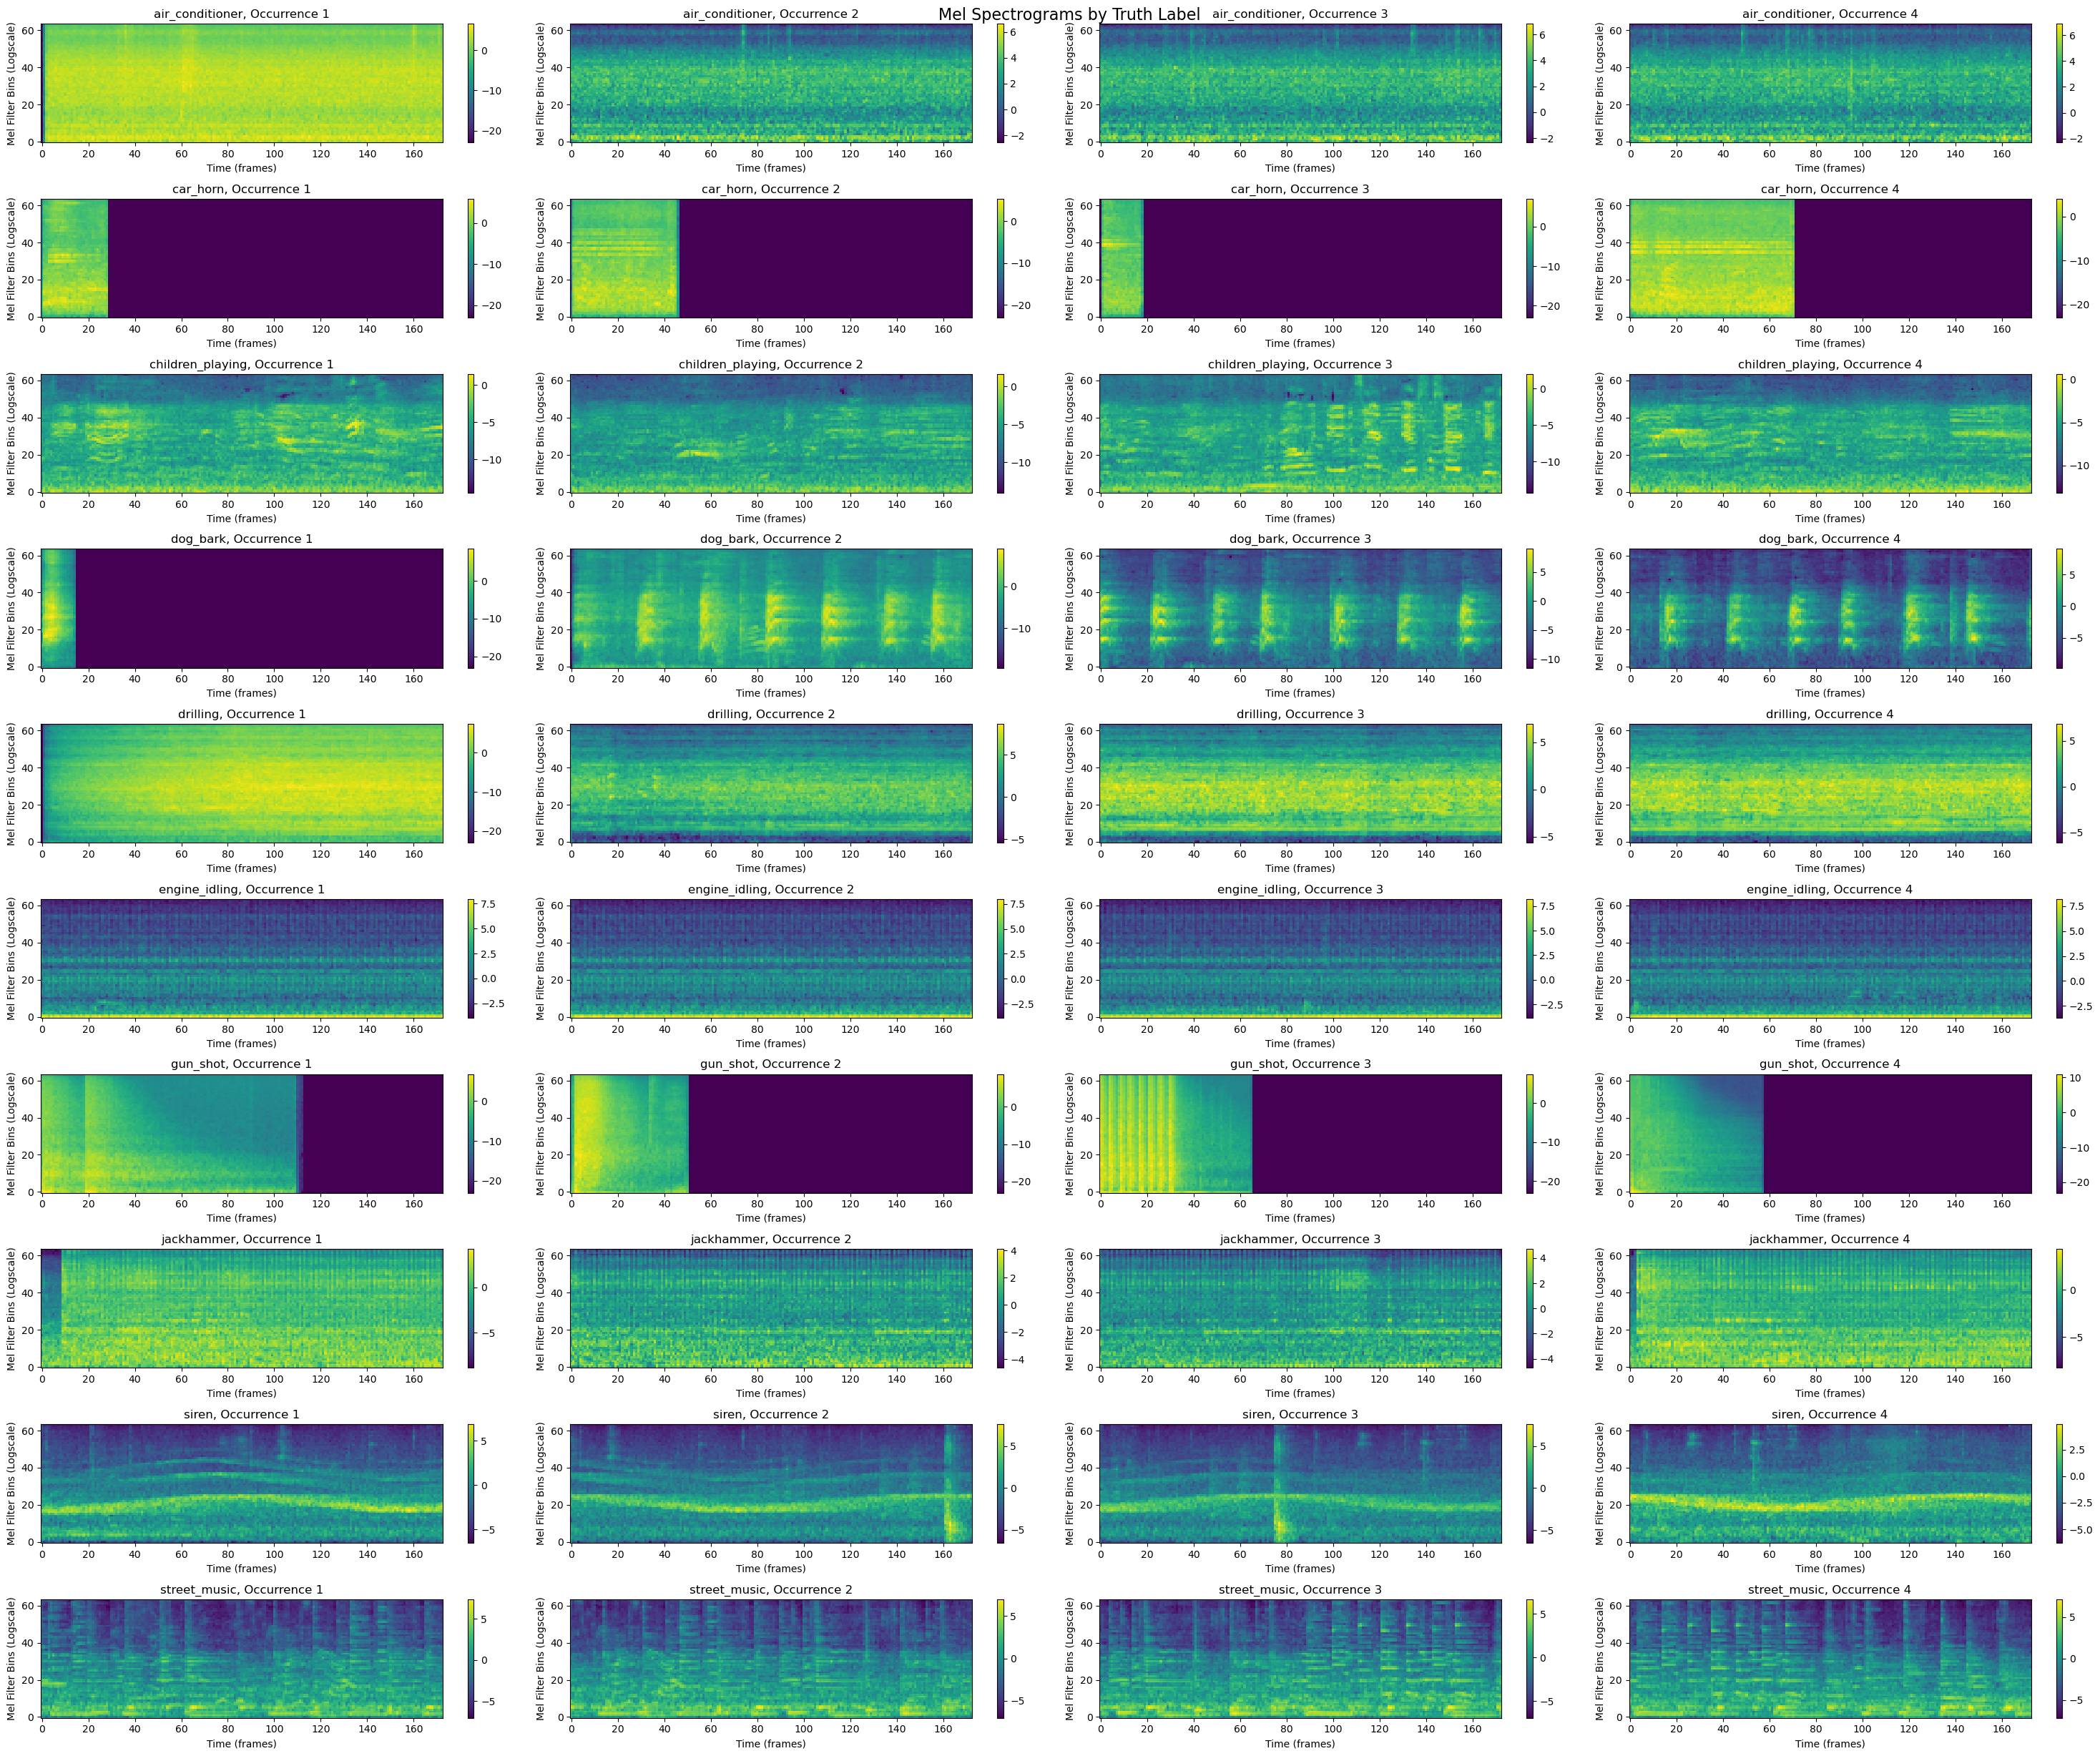

In [3]:
mel_spectrograms_by_label = {label: [] for label in range(10)}  # Dictionary to store spectrograms by label
appearances_by_label = {label: 0 for label in range(10)}  # Track occurrences for each label

# Find the first 4 occurrences of each label in the entire dataset
for i in range(len(usd)):
    mel_spec, label = usd[i]
    if appearances_by_label[label] < 4:  # Collect only 4 occurrences for each label
        mel_spectrograms_by_label[label].append(mel_spec)
        appearances_by_label[label] += 1
    
    # Break if all labels have 4 occurrences
    if all(appearances == 4 for appearances in appearances_by_label.values()):
        break

plot_mel_spectrograms_by_label(mel_spectrograms_by_label)


#### Loading the data

Our data will proceed to be split randomly into three groups:
* **Training (70%)**: The majority of the data is allocated to training the model and ensures it has enough examples to learn from. The more data the model sees during training, the better it can learn relational features between dimensions.
* **Validation (15%)**: We use this to tune hyperparameters such as learning rate, activation functions, and batch size. It helps us monitor model performance without overfitting to the training set.
* **Testing (15%)**: After training and validation, the model is tested on the test set to assess its generalization performance.

A smaller batch size of 64 is used for the training set, as the training process benefits from noise. It helps the model explore the cross-entropy loss landscape more effectively, potentially leading to better performance. With smaller batches, the model updates its weights more frequently, which can speed up convergence. 

For the validation and test datasets, a larger batch size of 256 is used, as we do not use this data to update model weights; we are only using them to evaluate performance. Therefore, using a large batch size reduces the number of forward passes needed to compute metrics like accuracy and loss, leading to faster evaluation.

In [4]:
train_dataset, val_dataset, test_dataset = split_data(usd, train_split=0.7, val_split=0.15, test_split=0.15)
train_loader = create_data_loader(train_dataset, batch_size=64) # size 6112
val_loader = create_data_loader(val_dataset, batch_size=256) # size 1309
test_loader = create_data_loader(test_dataset, batch_size=256) # size 1311

## The Convolutional Neural Network


It would probably be helpful at this point to explain what exactly a CNN is and how it is different than a simpler multi-layer perceptron classifer network.

A **Convolutional Neural Network (CNN)** is a type of deep learning model designed to process data that has a grid-like structure, such as images, videos, or in our case: audio spectrograms. CNNs are particularly effective for tasks involving spatial or temporal hierarchies, where features at different scales and regions of the input data contribute to classification or prediction.

CNNs have some key components that set them apart from, say, rudimentary MLP classification:
* **Convolutional Blocks**: A group of sublayers that apply convolution operations to input data to automatically learn useful features, such as edges in images. They typically consist of the following sublayers:
  * **Convolutional Layer**: This layer applies a small set of 2D filters (kernels) to the input data. Each filter slides over the 2D input and computes a dot product between the filter's randomly assigned weights and the input, producing a feature map. The filters are **learned during training** and detect local patterns such as edges, textures, or frequency patterns.
  * **Activation Layer**: After convolution, the result is passed through a non-linear activation functiion (e.g., ReLU, Leaky ReLU, Tanh, or sigmoid). ReLU (Rectified Linear Unit) is most common because it reduces the vanishing gradient problem and speeds up training. The activation function introduces non-linearity to the network, allowing it to learn more complex features.
  * **Pooling Layer**: This layer reduces the size of the feature maps by downsampling the input, reducing the computational load while retaining the most important features. Pooling also helps make the model invariant to small shifts and distortions in the input data.

After feature extraction, a **Fully Connected Layer** performs the final classification by connecting all learned features into a flattened structure. 

The CNN we are testing is built with four convolution blocks, each with a convolution layer, activation layer, and a pooling layer. Each block also expands the data into more channels; the first block takes a one-channel input and applies 16 different filters to the input. This will output 16 learned feature layers. The second block takes a 16-channel input and has 32 different filters applied to it, expanding it into 32 learned feature layers and so on. The fourth convolution block will output 128 learned feature layers to the fully-connected layer.

The output of the final block is flattened and a fully-connected linear layer outputs the final (1, 10) classification vector. In the following tests, we will compare different activation functions within our 4-convolution block CNN.

In [5]:
# An example of a ReLU-driven CNN that we will be using:

class CNN_ReLU(nn.Module):

    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2
            ),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(7680, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        # predictions = self.softmax(logits)
        return logits

    def get_loss(self, learning_rate):
        loss = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        return loss, optimizer

#### Initializing the models

I've already created classes for each variation of our 4-block CNN in `classify-audio.py`. They will all be trained on the same training, validation, and testing datasets, with the only difference of what activation function their convolution blocks are driven by:
* ReLU (Rectified Linear Unit)
* Leaky ReLU
* Hyperbolic Tangent (Tanh)
* Sigmoid

Since the activation function is applied element-wise, it does not change the dimensions of the data. We can see the way each layer changes the data's shape using `summary`:

In [6]:
IDEAL_INPUT_SIZE = (1, 64, 173)
cnn_relu = CNN_ReLU().to(device)
cnn_leaky = CNN_LeakyReLU().to(device)
cnn_tanh = CNN_Tanh().to(device)
cnn_sigmoid = CNN_Sigmoid().to(device)

summary(cnn_relu, IDEAL_INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 66, 175]             160
              ReLU-2          [-1, 16, 66, 175]               0
         MaxPool2d-3           [-1, 16, 33, 87]               0
            Conv2d-4           [-1, 32, 35, 89]           4,640
              ReLU-5           [-1, 32, 35, 89]               0
         MaxPool2d-6           [-1, 32, 17, 44]               0
            Conv2d-7           [-1, 64, 19, 46]          18,496
              ReLU-8           [-1, 64, 19, 46]               0
         MaxPool2d-9            [-1, 64, 9, 23]               0
           Conv2d-10          [-1, 128, 11, 25]          73,856
             ReLU-11          [-1, 128, 11, 25]               0
        MaxPool2d-12           [-1, 128, 5, 12]               0
          Flatten-13                 [-1, 7680]               0
           Linear-14                   

We can also visualize the data propogation down the CNN using an acyclic graph:

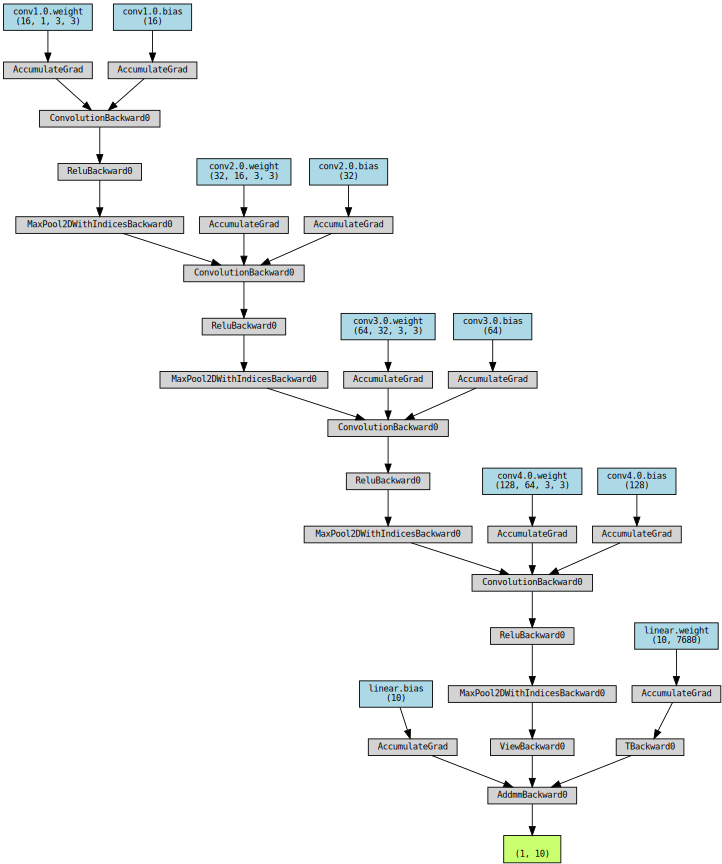

In [7]:
visualize_cnn(cnn_relu, device, IDEAL_INPUT_SIZE)

#### Training the Models

I created a training process `train_cnn` in `classify_audio.py` that trains a CNN model. It took me about an hour to train all four models with 10 epochs and a learning rate of 0.001. (Note that I used the Cross-Entropy Loss criterion as well as the Adam stochastic gradient descent optimizer.) I stored the training loss, validation loss, and testing accuracy for each of the four models in a JSON file so you don't have to sit around for an hour or download the 8GB dataset to read further.

In `train_cnn`, each training pass would look something like this:
1. At the beginning of an epoch, our training set (6112 elements) is divided into 96 batches of size 64. 
2. The optimizer gradient (Adam) is reset to zero.
3. A batch is passed forward into the CNN.
4. Loss is computed and passed backwards to find the loss with respect to each parameter of the CNN.
5. The optimizer changes each parameter with respect to the computed loss.
6. Repeat 1-5 on a different batch for one epoch (96 times)

At the end of an epoch, we do a pass on the validation dataset:
1. Our validation set (1309 elements) is divided into 6 batches of size 256.
2. Reset total validation loss to 0.
3. A batch is passed forward into the CNN. 
4. Loss is computed.

Before starting another epoch, we also do a pass on the testing set to calculate accuracy:
1. We disable gradient calculation with `torch.no_grad()`.
2. Our testing set (1311 elements) is divided into 6 batches of size 256.
3. A batch is passed forward into the CNN.
4. We get predictions for each element (the index of the maximum logit)
5. We calculate accuracy from correct predictions.

We would then start over for the next epoch for 10 epochs.

In [8]:
EPOCHS = 10
LEARNING_RATE = 0.001

# What you would have to do otherwise:

# relu_results = train_cnn(cnn_relu, train_loader, val_loader, test_loader, EPOCHS, LEARNING_RATE)
# leaky_results = train_cnn(cnn_leaky, train_loader, val_loader, test_loader, EPOCHS, LEARNING_RATE)
# tanh_results = train_cnn(cnn_tanh, train_loader, val_loader, test_loader, EPOCHS, LEARNING_RATE)
# sigmoid_results = train_cnn(cnn_sigmoid, train_loader, val_loader, test_loader, EPOCHS, LEARNING_RATE)

# results = {
#     'relu': relu_results,
#     'leaky_relu': leaky_results,
#     'tanh': tanh_results,
#     'sigmoid': sigmoid_results
# }

result_path = os.path.join(cwd, 'results.json')
with open(result_path, 'r') as file:
    results = json.load(file)

## Model Analysis

We see below the cross-entropy loss behavior of all four models. It seems that our ReLU, Leaky ReLU, and Tanh variations are performing with similar and decent loss progression, converging at a low cross-entropy metric (at or below 0.5) by the final batch.

However, it is very obvious that the sigmoid variation is struggling to perform as well. It barely makes it under a cross-entropy of 1.5. 

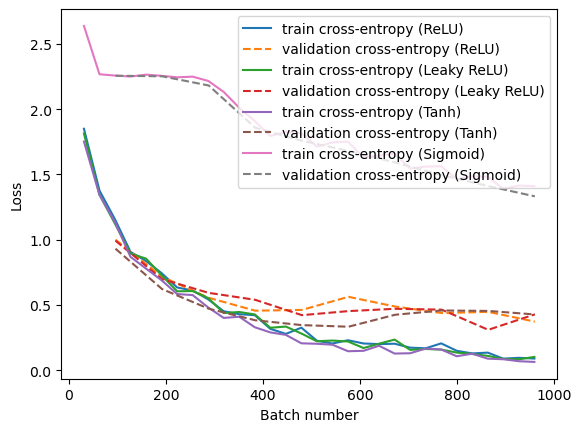

In [9]:
relu_results = results['relu']
leaky_results = results['leaky_relu']
tanh_results = results['tanh']
sigmoid_results = results['sigmoid']

plt.plot(relu_results['train_index'],relu_results['train_losses'])
plt.plot(relu_results['val_index'], relu_results['val_losses'], '--')

plt.plot(leaky_results['train_index'],leaky_results['train_losses'])
plt.plot(leaky_results['val_index'], leaky_results['val_losses'], '--')

plt.plot(tanh_results['train_index'],tanh_results['train_losses'])
plt.plot(tanh_results['val_index'], tanh_results['val_losses'], '--')

plt.plot(sigmoid_results['train_index'],sigmoid_results['train_losses'])
plt.plot(sigmoid_results['val_index'], sigmoid_results['val_losses'], '--')

plt.legend(['train cross-entropy (ReLU)', 'validation cross-entropy (ReLU)',
            'train cross-entropy (Leaky ReLU)', 'validation cross-entropy (Leaky ReLU)',
            'train cross-entropy (Tanh)', 'validation cross-entropy (Tanh)',
            'train cross-entropy (Sigmoid)', 'validation cross-entropy (Sigmoid)'])
plt.xlabel('Batch number')
plt.ylabel('Loss')

# plot_path = os.path.join(cwd, 'training_loss_plot.png')
# plt.savefig(plot_path)

plt.show()

The accuracy plot below shows a similar disparity between our first three models and the poor sigmoid model. The ReLU, Leaky, and Tanh variants all converge to accuracies just under 90%, while the Sigmoid variant barely makes it to a 50% coin toss. 

This can be explained by the characteristics of the activation functions and how they impact the behavior of the model during training. The sigmoid function outputs values between 0 and 1, which can lead to saturation when inputs to the neurons are very large or very small. When the input is far from 0 (either positive or negative), the gradient of the Sigmoid function becomes very small (close to 0). This phenomenon is called the **vanishing gradient problem**. When the gradients vanish, the weights in the earlier layers of the network stop updating effectively during backpropagation. This causes the network to struggle to learn and converge properly.

The derivative of the sigmoid function is very small except for inputs near 0. This can cause slow learning, as updates to the weights are very, very small during gradient descent. When the network has many layers, such as in a CNN with 4 convolutional blocks, the small gradients accumulate and lead to even slower updates, making it difficult for the network to learn meaningful patterns from the data.

Furthermore, the clamping to values 0 and 1 can lead to output values being too small. ReLU, Leaky, and Tanh allow for broader ranges of outputs, which give the model more capacity to learn complex representations. 

* **ReLU** outputs values directly proportional to the input when positive, and 0 otherwise. This function doesn't saturate for positive values and allows for efficient gradient propagation and faster learning. It is less likely to suffer to suffer from the vanishing gradient problem and is therefore most often used for convolutional blocks in CNNs.
* **Leaky ReLU** is ReLU, but with a small slope for negative inputs, which avoids the issue of neurons "dying" (outputting constant 0). This ensures better gradient flow even for negative inputs.
* **Tanh** outputs values between -1 and 1, so its outputs are centered around 0. This can sometimes lead to faster convergences compared to Sigmoid, though Tanh sometimes suffers from vanishing gradients. 
  
The 0-to-1 clamping behavior of Sigmoidis helpful for binary classification problems but is problematic in deep architecture. It is often used in the final layer of binary classification models (as its output is easily interpretable as probabilities), but it is rarely used in intermediate layers like this.

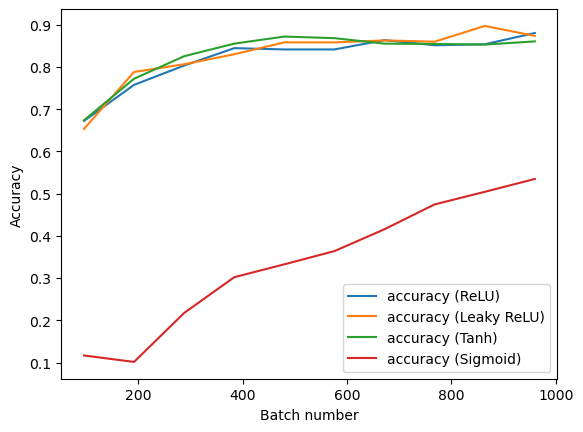

In [10]:

plt.plot(relu_results['val_index'], relu_results['accuracies'])
plt.plot(leaky_results['val_index'], leaky_results['accuracies'])
plt.plot(tanh_results['val_index'], tanh_results['accuracies'])
plt.plot(sigmoid_results['val_index'], sigmoid_results['accuracies'])


plt.legend(['accuracy (ReLU)',
            'accuracy (Leaky ReLU)',
            'accuracy (Tanh)',
            'accuracy (Sigmoid)'])
plt.xlabel('Batch number')
plt.ylabel('Accuracy')

# plot_path = os.path.join(cwd, 'accuracy_plot.png')
# plt.savefig(plot_path)

plt.show()